In [ ]:
## Image augmentation
#!pip install imgaug

## ONLY used for dice metric and IOU metric computation, models are made from scratch
#!pip install -U segmentation-models

## Required to save models in HDF5 format
#!pip install pyyaml h5py

## Install nibabel
#!pip install nibabel

## Install scikit-learn library
#!pip install sklearn

## Install tensorflow and keras
#!pip uninstall tensorflow==2.2.0
#!pip install keras
#!pip install keras-segmentation

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import cv2 as cv
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
import keras_segmentation as ks

warnings.filterwarnings('ignore')
%matplotlib inline
print("Version: ", tf.version.VERSION)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "not available")

Version:  2.2.0
GPU is not available


## 1. Load metada

In [2]:
metadata = pd.read_csv('metadata.csv')
metadata.replace('../input/covid19-ct-scans/', '', regex=True, inplace=True)
print(metadata.shape)
metadata.head()

(20, 4)


,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,ct_scans/coronacases_org_001.nii,lung_mask/coronacases_001.nii,infection_mask/coronacases_001.nii,lung_and_infection_mask/coronacases_001.nii
1,ct_scans/coronacases_org_002.nii,lung_mask/coronacases_002.nii,infection_mask/coronacases_002.nii,lung_and_infection_mask/coronacases_002.nii
2,ct_scans/coronacases_org_003.nii,lung_mask/coronacases_003.nii,infection_mask/coronacases_003.nii,lung_and_infection_mask/coronacases_003.nii
3,ct_scans/coronacases_org_004.nii,lung_mask/coronacases_004.nii,infection_mask/coronacases_004.nii,lung_and_infection_mask/coronacases_004.nii
4,ct_scans/coronacases_org_005.nii,lung_mask/coronacases_005.nii,infection_mask/coronacases_005.nii,lung_and_infection_mask/coronacases_005.nii


In [3]:
# img_size is the preferred image size to which the image is to be resized
img_size = 512

In [4]:
clahe = cv.createCLAHE(clipLimit=3.0)

def clahe_enhancer(img, clahe, axes):
    '''Contract Limited Adaptive Histogram Equalizer'''
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()
        
    return(clahe_img)

Number of slices:  301


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


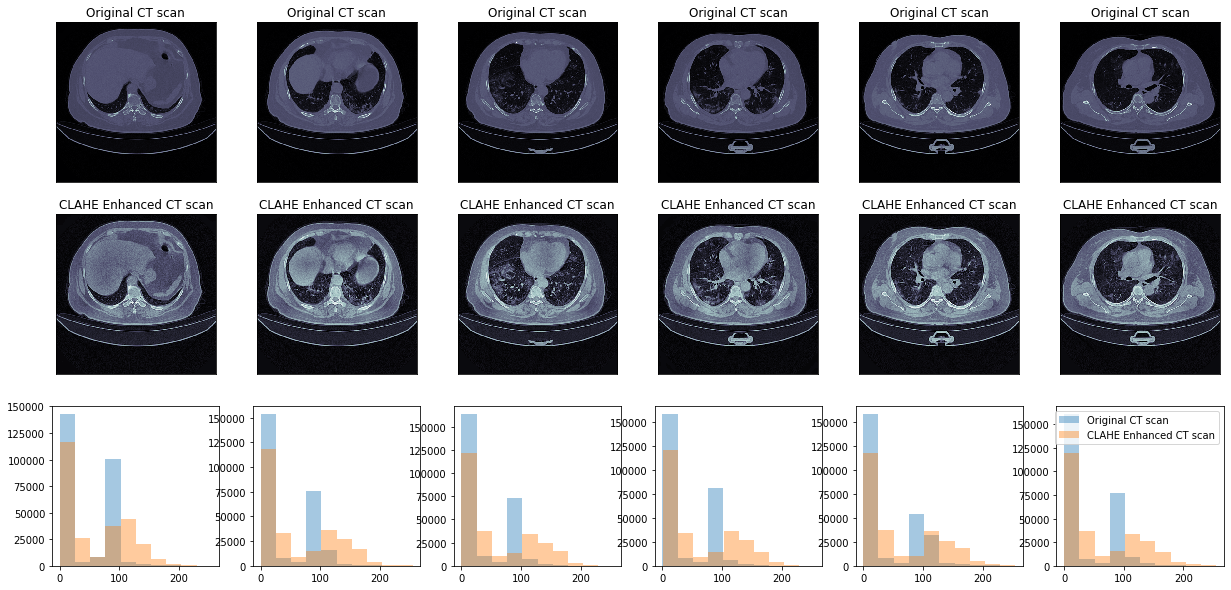

In [5]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(21,10))    

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))

In [6]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9
    img = cv.filter2D(img, -1, kernel)
    
    ret, thresh = cv.threshold(img, 50, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(thresh, 2, 1)
    #Areas = [cv.contourArea(cc) for cc in contours]; print(Areas)
    
    # filter contours that are too large or small
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    # margin is the minimum distance from the edges of the image, as a fraction
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]
    
def crop_img(img, axes) :
    contours = get_contours(img)
    #plt.figure() # uncomment to troubleshoot
    #canvas = np.zeros_like(img)
    #cv.drawContours(canvas , contours, -1, (255, 255, 0), 1)
    #plt.imshow(canvas)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds

Number of slices:  301


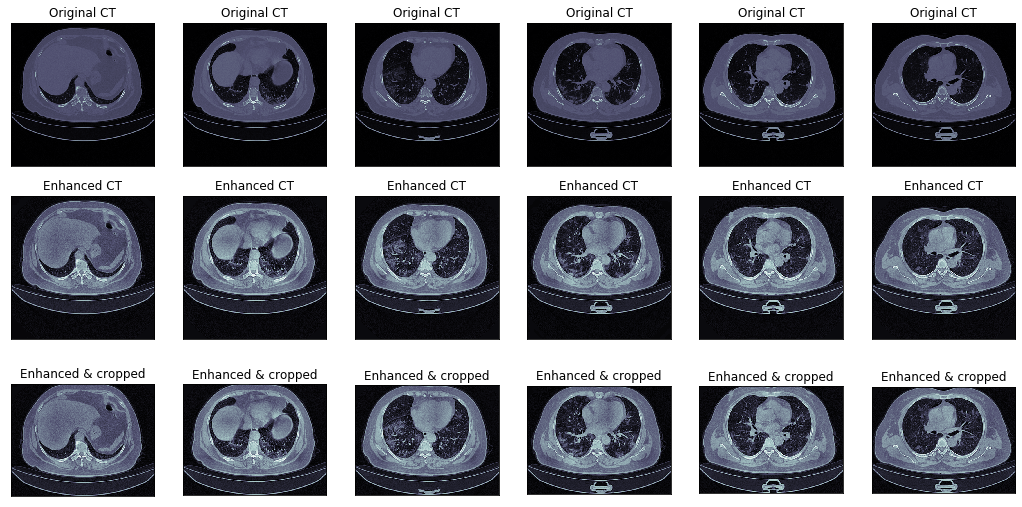

In [7]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,9))    

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    _, bounds = crop_img(img, [])
    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original CT')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced CT')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])
    
    cropped_img = crop_(clahe_img, bounds)
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Enhanced & cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])


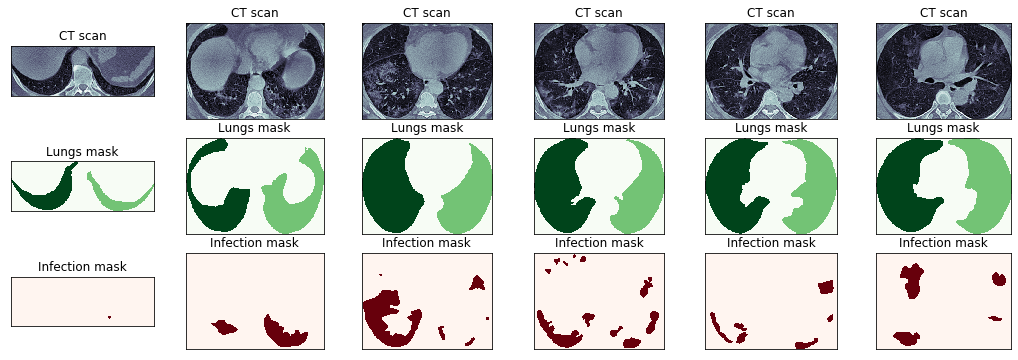

In [8]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
lungs = nib.load(metadata.loc[0, 'lung_mask'])
infec = nib.load(metadata.loc[0, 'infection_mask'])
slices = cts.shape[2]
    
arr_cts = cts.get_fdata()
arr_lungs = lungs.get_fdata()
arr_infec = infec.get_fdata()

arr_cts = np.rot90(np.array(arr_cts))
arr_lungs = np.rot90(np.array(arr_lungs))
arr_infec = np.rot90(np.array(arr_infec))

arr_cts = arr_cts[:, :, range(80,200,20)]
arr_lungs = arr_lungs[:, :, range(80,200,20)]
arr_infec = arr_infec[:, :, range(80,200,20)]

arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,6))    

for ii in range(arr_cts.shape[0]):
    img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    xmax, xmin = img_lungs.max(), img_lungs.min()
    img_lungs = (img_lungs - xmin)/(xmax - xmin)
    cropped_lungs, bounds = crop_img(img_lungs, [])
    
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    cropped_infec = crop_(img_infec, bounds)
    
    axes[0,ii].imshow(cropped_ct, cmap='bone')
    axes[0,ii].set_title("CT scan")
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    axes[1,ii].imshow(cropped_lungs, cmap='Greens')
    axes[1,ii].set_title("Lungs mask")
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    axes[2,ii].imshow(cropped_infec, cmap='Reds')
    axes[2,ii].set_title("Infection mask")
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

## Load all the data

In [9]:
cts_all = []
lungs_all = []
infects_all = []
max_w, max_h = 0, 0 #max width and height

for fnum in tqdm.tqdm(range(20)) : #range(metadata.shape[0])) :
    cts = nib.load(metadata.loc[fnum, 'ct_scan'])
    lungs = nib.load(metadata.loc[fnum, 'lung_mask'])
    infec = nib.load(metadata.loc[fnum, 'infection_mask'])
    
    slices = cts.shape[2]

    arr_cts = cts.get_fdata()
    arr_lungs = lungs.get_fdata()
    arr_infec = infec.get_fdata()

    arr_cts = np.rot90(np.array(arr_cts))
    arr_lungs = np.rot90(np.array(arr_lungs))
    arr_infec = np.rot90(np.array(arr_infec))

    arr_cts = arr_cts[:, :, round(slices*0.2):round(slices*0.8)]
    arr_lungs = arr_lungs[:, :, round(slices*0.2):round(slices*0.8)]
    arr_infec = arr_infec[:, :, round(slices*0.2):round(slices*0.8)]

    arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
    arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
    arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))
    
    for ii in range(arr_cts.shape[0]):
        img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), 
                              interpolation=cv.INTER_AREA)
        xmax, xmin = img_lungs.max(), img_lungs.min()
        img_lungs = (img_lungs - xmin)/(xmax - xmin)
        cropped_lungs, bounds = crop_img(img_lungs, [])
        lungs_all.append(cropped_lungs)
        
        h, w = cropped_img.shape
        max_h, max_w = max(max_h, h), max(max_w, w)

        img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), 
                           interpolation=cv.INTER_AREA)
        xmax, xmin = img_ct.max(), img_ct.min()
        img_ct = (img_ct - xmin)/(xmax - xmin)
        clahe_ct = clahe_enhancer(img_ct, clahe, [])
        cropped_ct = crop_(clahe_ct, bounds)
        cts_all.append(cropped_ct)

        img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), 
                              interpolation=cv.INTER_AREA)
        cropped_infec = crop_(img_infec, bounds)
        infects_all.append(cropped_infec)

100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


In [10]:
print(len(cts_all))

2112


## Resize and reshape

In [11]:
num_pix = 100
del_lst = []
for ii in tqdm.tqdm(range(len(cts_all))) :
    try :
        cts_all[ii] = cv.resize(cts_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        cts_all[ii] = np.reshape(cts_all[ii], (num_pix, num_pix, 1))

        lungs_all[ii] = cv.resize(lungs_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        lungs_all[ii] = np.reshape(lungs_all[ii], (num_pix, num_pix, 1))

        infects_all[ii] = cv.resize(infects_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        infects_all[ii] = np.reshape(infects_all[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del cts_all[idx]
    del lungs_all[idx]
    del infects_all[idx]

100%|██████████| 2112/2112 [00:01<00:00, 2012.50it/s]


* See the following fully processed sample

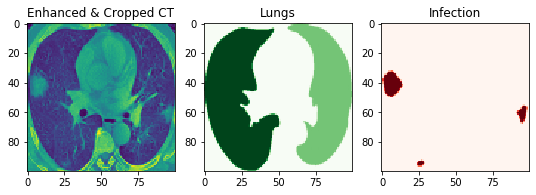

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))

axes[0].imshow(cts_all[250][:, :, 0])
axes[0].set_title("Enhanced & Cropped CT")

axes[1].imshow(lungs_all[250][:, :, 0], cmap='Greens')
axes[1].set_title("Lungs")

axes[2].imshow(infects_all[250][:, :, 0], cmap='Reds')
axes[2].set_title("Infection");

## Dump the preprocessed data

In [ ]:
with open('preprocessed_cts.cp', 'wb') as myfile:
    pickle.dump({'cts_all': cts_all, 'lungs_all': lungs_all, 'infects_all': infects_all}, myfile)

In [13]:
infect_bool = np.ones((1, len(infects_all)))
for ii in range(len(infects_all)):
    if np.unique(infects_all[ii]).size == 1:
        infect_bool[0, ii] = 0
        
print("Number of CTs with no infection: %d" %(len(infects_all)-infect_bool.sum()))

#for index in sorted(no_masks, reverse = True):  
#    del infections[index]  
#    del cts[index]

Number of CTs with no infection: 491


* Notice how the infection can be distinguised clearly after enhancement.

* Saving the numpy arrays to later reuse the same preprocessing for other models rather than doing it again.

## Data augmentation pipeline

In [14]:
ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-15, 15)
    )
], random_order=True) # apply augmenters in random order

In [15]:
num_augs = round(len(cts_all)/2.)
rand_idx = np.random.randint(0, len(cts_all), size=num_augs)

sample_cts = [cts_all[ii] for ii in rand_idx]
sample_lungs = [lungs_all[ii] for ii in rand_idx]
sample_infects = [infects_all[ii] for ii in rand_idx]

In [16]:
seq_det = seq.to_deterministic()
cts_aug = seq_det.augment_images(sample_cts)
lungs_aug = seq_det.augment_images(sample_lungs)
infects_aug = seq_det.augment_images(sample_infects)

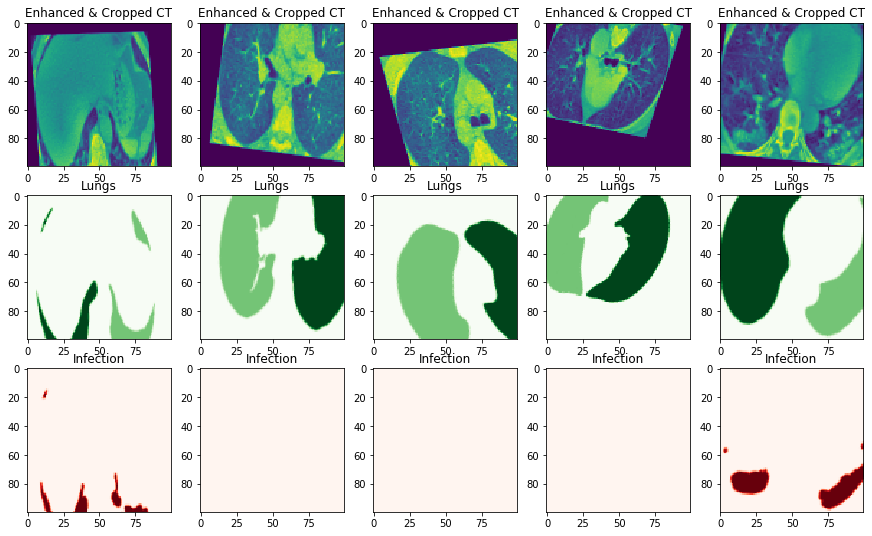

In [17]:
fig, axes = plt.subplots(3, 5, figsize=(15,9))

for ii in range(5) :
    axes[0, ii].imshow(cts_aug[ii*10+50][:, :, 0])
    axes[0, ii].set_title("Enhanced & Cropped CT")

    axes[1, ii].imshow(lungs_aug[ii*10+50][:, :, 0], cmap='Greens')
    axes[1, ii].set_title("Lungs")

    axes[2, ii].imshow(infects_aug[ii*10+50][:, :, 0], cmap='Reds')
    axes[2, ii].set_title("Infection");

## Pool augmented data and convert it

In [18]:
cts_all = tf.convert_to_tensor(cts_all)
cts_aug = tf.convert_to_tensor(cts_aug)
lungs_all = tf.convert_to_tensor(lungs_all)
lungs_aug = tf.convert_to_tensor(lungs_aug)
infects_all = tf.convert_to_tensor(infects_all)
infects_aug = tf.convert_to_tensor(infects_aug)

cts = tf.concat([cts_all, cts_aug], axis=0)
lungs = tf.concat([lungs_all, lungs_aug], axis=0)
infects = tf.concat([infects_all, infects_aug], axis=0)

In [19]:
indices = tf.range(start=0, limit=cts.shape[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)
                       
cts = tf.gather(cts, shuffled_indices)
lungs = tf.gather(lungs, shuffled_indices)
infects = tf.gather(infects, shuffled_indices)

print(cts.shape, lungs.shape, infects.shape)

(3157, 100, 100, 1) (3157, 100, 100, 1) (3157, 100, 100, 1)


## Save augmented data

In [20]:
with open('augmented_cts.cp', 'wb') as myfile:
    pickle.dump({'cts': cts, 'lungs': lungs, 'infects': infects}, myfile)

* Just overlaying infection masks over the corresponding CT scans

In [21]:
def plot_cts_infects(ct, infect, axes) :

    axes[0].imshow(ct[:,:,0], cmap='bone')
    axes[0].set_title('CT image')

    axes[1].imshow(ct[:,:,0], cmap='bone')
    axes[1].imshow(infect[:,:,0], alpha=0.5, cmap='nipy_spectral')
    axes[1].set_title('Infection')

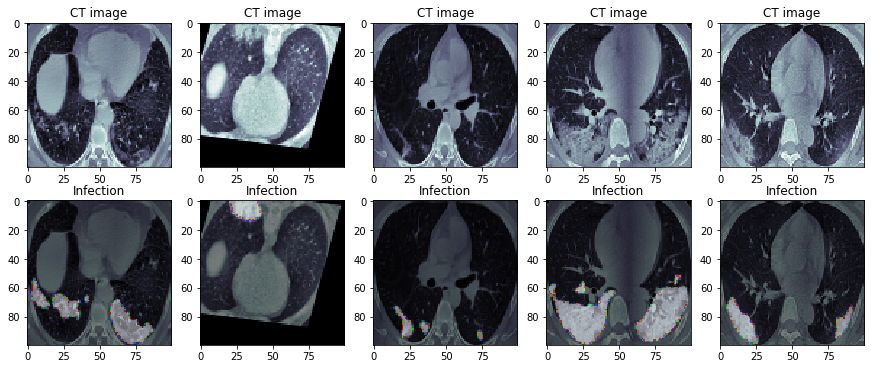

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for ii, idx in enumerate(range(150, 350, 40)) :
    plot_cts_infects(cts[idx], infects[idx], list(axes[:,ii]))

In [41]:
## see https://github.com/keras-team/keras/issues/9395

def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred): #Binary Cross-Entropy
    loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha, beta  = 0.5, 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred
    p1 = ones-y_pred
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) 
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + 
                     K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1*m2)
    score = (2.*K.sum(w*intersection) + smooth) / (K.sum(w*m1) + K.sum(w*m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), 
                             padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5.*K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

## Cosine Annealing Learning Rate

An effective snapshot ensemble requires training a neural network with an aggressive learning rate schedule.

The cosine annealing schedule is an example of an aggressive learning rate schedule where learning rate starts high and is dropped relatively rapidly to a minimum value near zero before being increased again to the maximum.

We can implement the schedule as described in the 2017 paper “Snapshot Ensembles: Train 1, get M for free.” The equation requires the total training epochs, maximum learning rate, and number of cycles as arguments as well as the current epoch number. The function then returns the learning rate for the given epoch.

See https://machinelearningmastery.com/snapshot-ensemble-deep-learning-neural-network/

In [24]:
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(callbacks.Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
 
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = np.floor(n_epochs/n_cycles)
        cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (np.cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        K.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

In [25]:
# define learning rate callback
n_epochs = 200
lrmax = 0.002
n_cycles = n_epochs / 25
lr_cb = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, lrmax)

* All the hyperparameters are put in place after repeating trial and error for a fixed number of epochs.

## Model building blocks

In [33]:
def cts_block_1 (x_in, conv2Dfilters, maxpool2Dsize=(2,2)) :
    x = Conv2D(conv2Dfilters, (3,3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x)
    x_inter = BatchNormalization() (x)
    x = MaxPooling2D(maxpool2Dsize) (x_inter) 
    x = Dropout(0.25)(x) 
    
    return x, x_inter

def cts_block_2 (x_in, conv2Dfilters) :
    x = BatchNormalization() (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x) 
    
    return x

## keras model with one input (CTs) and two segmented output (lungs & infections)

In [34]:
def cts_model (input_shape) :
    
    x_input = Input(input_shape)
    
    ##################################  LUNG SEGMENTATION  ######################
    x, x1 = cts_block_1 (x_input, 32, maxpool2Dsize=(2,2)) #x: 50x50
    x, x2 = cts_block_1 (x, 64, maxpool2Dsize=(2,2)) #x: 25x25
    x, _ = cts_block_1 (x, 128, maxpool2Dsize=(1,1)) #x: 25x25
    x, _ = cts_block_1 (x, 256, maxpool2Dsize=(1,1)) #x: 25x25

    x = cts_block_2 (x, 256) #x: 25x25
    
    x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x) #x: 50x50
    x = cts_block_2 (x, 128) #x: 50x50

    x = Conv2DTranspose(64, (2, 2), padding='same') (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = cts_block_2 (x, 64) #x: 50x50

    x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = cts_block_2 (x, 32) #x: 100x100

    lung_seg = Conv2D(1, (1, 1), activation='sigmoid', name='lung_output') (x) #x: 100x100

    ##################################  INFECTION SEGMENTATION  ######################
    x, x1 = cts_block_1 (lung_seg, 32, maxpool2Dsize=(2,2)) #x: 50x50
    x, x2 = cts_block_1 (x, 64, maxpool2Dsize=(2,2)) #x: 25x25
    x, _ = cts_block_1 (x, 128, maxpool2Dsize=(1,1)) #x: 25x25
    x, _ = cts_block_1 (x, 256, maxpool2Dsize=(1,1)) #x: 25x25
    
    x = cts_block_2 (x, 256) #x: 25x25
    
    x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x) #x: 50x50
    x = cts_block_2 (x, 128) #x: 50x50

    x = Conv2DTranspose(64, (2, 2), padding='same') (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = cts_block_2 (x, 64) #x: 50x50

    x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = cts_block_2 (x, 32) #x: 100x100

    infect_seg = Conv2D(1, (1, 1), activation='sigmoid', name='infect_output') (x) # identifying infections

    model = Model(inputs=x_input, outputs=[lung_seg, infect_seg], name='cts_model')
    
    return model

In [35]:
ctsModel = cts_model(cts.shape[1:])
ctsModel.summary()

Model: "cts_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 100, 100, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 100, 100, 32) 9248        conv2d_17[0][0]                  
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 100, 100, 32) 128         conv2d_18[0][0]                  
__________________________________________________________________________________________

## Split data into train and validation sets

In [36]:
train_size = int(0.8*cts.shape[0])
test_size = int(0.1*cts.shape[0])

X_train, yl_train, yi_train = (cts[:train_size]/255, 
                               lungs[:train_size], 
                               infects[:train_size])

X_valid, yl_valid, yi_valid = (cts[train_size:train_size+test_size]/255, 
                               lungs[train_size:train_size+test_size],
                               infects[train_size:train_size+test_size])

X_test, yl_test, yi_test = (cts[train_size+test_size:]/255, 
                            lungs[train_size+test_size:],
                            infects[train_size+test_size:])

print(X_train.shape, yl_train.shape, yi_train.shape)
print(X_test.shape, yl_test.shape, yi_test.shape)

(2525, 100, 100, 1) (2525, 100, 100, 1) (2525, 100, 100, 1)
(317, 100, 100, 1) (317, 100, 100, 1) (317, 100, 100, 1)


## Callback (model checkpointing with the highest validation dice coefficient)

In [49]:
batch_size = 128
epochs = n_epochs

checkpoint_fpath = "ctsmodel-lungs-infect-seg.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_infect_output_dice_coeff', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)

## Training

In [50]:
optim = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.99)

loss_dict = {'lung_output': bce_dice_loss, 'infect_output': bce_dice_loss}
loss_weight_dict = {'lung_output': 1.0, 'infect_output': 1.0}

ctsModel.compile(optimizer=optim, loss=loss_dict, loss_weights=loss_weight_dict, metrics=[dice_coeff])

ctsRes = ctsModel.fit(x=X_train, 
                      y={'lung_output': yl_train, 'infect_output': yi_train}, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_valid, 
                                       {'lung_output': yl_valid, 'infect_output': yi_valid}),
                      callbacks = [cts_checkpoint_cb, lr_cb])


Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.5927 - lung_output_loss: 0.2972 - infect_output_loss: 0.2955 - lung_output_dice_coeff: 0.7510 - infect_output_dice_coeff: 0.5550 
Epoch 00001: val_infect_output_dice_coeff improved from -inf to 0.02846, saving model to ctsmodel-lungs-infect-seg.hdf5
20/20 [==============================] - 361s 18s/step - loss: 0.5927 - lung_output_loss: 0.2972 - infect_output_loss: 0.2955 - lung_output_dice_coeff: 0.7510 - infect_output_dice_coeff: 0.5550 - val_loss: 1.0826 - val_lung_output_loss: 0.4170 - val_infect_output_loss: 0.6656 - val_lung_output_dice_coeff: 0.6328 - val_infect_output_dice_coeff: 0.0285
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.5331 - lung_output_loss: 0.2876 - infect_output_loss: 0.2454 - lung_output_dice_coeff: 0.7590 - infect_output_dice_coeff: 0.6175 
Epoch 00002: val_infect_output_dice_coeff improved from 0.02846 to 0.14260, saving model to ctsmodel-lungs-infect-seg.hdf5
20

Epoch 14/200
20/20 [==============================] - ETA: 0s - loss: 0.4360 - lung_output_loss: 0.2674 - infect_output_loss: 0.1686 - lung_output_dice_coeff: 0.7759 - infect_output_dice_coeff: 0.7379 
Epoch 00014: val_infect_output_dice_coeff did not improve from 0.44091
20/20 [==============================] - 364s 18s/step - loss: 0.4360 - lung_output_loss: 0.2674 - infect_output_loss: 0.1686 - lung_output_dice_coeff: 0.7759 - infect_output_dice_coeff: 0.7379 - val_loss: 0.7455 - val_lung_output_loss: 0.3293 - val_infect_output_loss: 0.4162 - val_lung_output_dice_coeff: 0.7361 - val_infect_output_dice_coeff: 0.4373
Epoch 15/200
20/20 [==============================] - ETA: 0s - loss: 0.4281 - lung_output_loss: 0.2617 - infect_output_loss: 0.1664 - lung_output_dice_coeff: 0.7862 - infect_output_dice_coeff: 0.7389 
Epoch 00015: val_infect_output_dice_coeff did not improve from 0.44091
20/20 [==============================] - 364s 18s/step - loss: 0.4281 - lung_output_loss: 0.2617 - in

Epoch 27/200
20/20 [==============================] - ETA: 0s - loss: 0.4468 - lung_output_loss: 0.2607 - infect_output_loss: 0.1861 - lung_output_dice_coeff: 0.7832 - infect_output_dice_coeff: 0.7084 
Epoch 00027: val_infect_output_dice_coeff did not improve from 0.74361
20/20 [==============================] - 365s 18s/step - loss: 0.4468 - lung_output_loss: 0.2607 - infect_output_loss: 0.1861 - lung_output_dice_coeff: 0.7832 - infect_output_dice_coeff: 0.7084 - val_loss: 0.6165 - val_lung_output_loss: 0.3039 - val_infect_output_loss: 0.3126 - val_lung_output_dice_coeff: 0.7953 - val_infect_output_dice_coeff: 0.5286
Epoch 28/200
20/20 [==============================] - ETA: 0s - loss: 0.4615 - lung_output_loss: 0.2682 - infect_output_loss: 0.1933 - lung_output_dice_coeff: 0.7774 - infect_output_dice_coeff: 0.7004 
Epoch 00028: val_infect_output_dice_coeff did not improve from 0.74361
20/20 [==============================] - 365s 18s/step - loss: 0.4615 - lung_output_loss: 0.2682 - in

Epoch 53/200
20/20 [==============================] - ETA: 0s - loss: 0.4084 - lung_output_loss: 0.2454 - infect_output_loss: 0.1630 - lung_output_dice_coeff: 0.7886 - infect_output_dice_coeff: 0.7466 
Epoch 00053: val_infect_output_dice_coeff did not improve from 0.77951
20/20 [==============================] - 370s 19s/step - loss: 0.4084 - lung_output_loss: 0.2454 - infect_output_loss: 0.1630 - lung_output_dice_coeff: 0.7886 - infect_output_dice_coeff: 0.7466 - val_loss: 0.7022 - val_lung_output_loss: 0.2566 - val_infect_output_loss: 0.4456 - val_lung_output_dice_coeff: 0.8016 - val_infect_output_dice_coeff: 0.4628
Epoch 54/200
20/20 [==============================] - ETA: 0s - loss: 0.3987 - lung_output_loss: 0.2421 - infect_output_loss: 0.1566 - lung_output_dice_coeff: 0.7927 - infect_output_dice_coeff: 0.7554 
Epoch 00054: val_infect_output_dice_coeff did not improve from 0.77951
20/20 [==============================] - 375s 19s/step - loss: 0.3987 - lung_output_loss: 0.2421 - in

20/20 [==============================] - ETA: 0s - loss: 0.4021 - lung_output_loss: 0.2408 - infect_output_loss: 0.1613 - lung_output_dice_coeff: 0.7943 - infect_output_dice_coeff: 0.7486 
Epoch 00079: val_infect_output_dice_coeff did not improve from 0.77951
20/20 [==============================] - 364s 18s/step - loss: 0.4021 - lung_output_loss: 0.2408 - infect_output_loss: 0.1613 - lung_output_dice_coeff: 0.7943 - infect_output_dice_coeff: 0.7486 - val_loss: 0.5901 - val_lung_output_loss: 0.2617 - val_infect_output_loss: 0.3285 - val_lung_output_dice_coeff: 0.8018 - val_infect_output_dice_coeff: 0.6174
Epoch 80/200
20/20 [==============================] - ETA: 0s - loss: 0.3908 - lung_output_loss: 0.2366 - infect_output_loss: 0.1541 - lung_output_dice_coeff: 0.7929 - infect_output_dice_coeff: 0.7598 
Epoch 00080: val_infect_output_dice_coeff did not improve from 0.77951
20/20 [==============================] - 365s 18s/step - loss: 0.3908 - lung_output_loss: 0.2366 - infect_output_l

Epoch 105/200
20/20 [==============================] - ETA: 0s - loss: 0.4023 - lung_output_loss: 0.2355 - infect_output_loss: 0.1668 - lung_output_dice_coeff: 0.7987 - infect_output_dice_coeff: 0.7403 
Epoch 00105: val_infect_output_dice_coeff did not improve from 0.78121
20/20 [==============================] - 363s 18s/step - loss: 0.4023 - lung_output_loss: 0.2355 - infect_output_loss: 0.1668 - lung_output_dice_coeff: 0.7987 - infect_output_dice_coeff: 0.7403 - val_loss: 0.4819 - val_lung_output_loss: 0.2576 - val_infect_output_loss: 0.2242 - val_lung_output_dice_coeff: 0.7842 - val_infect_output_dice_coeff: 0.6697
Epoch 106/200
20/20 [==============================] - ETA: 0s - loss: 0.3760 - lung_output_loss: 0.2313 - infect_output_loss: 0.1447 - lung_output_dice_coeff: 0.7966 - infect_output_dice_coeff: 0.7743 
Epoch 00106: val_infect_output_dice_coeff did not improve from 0.78121
20/20 [==============================] - 363s 18s/step - loss: 0.3760 - lung_output_loss: 0.2313 - 

Epoch 131/200
20/20 [==============================] - ETA: 0s - loss: 0.3751 - lung_output_loss: 0.2264 - infect_output_loss: 0.1487 - lung_output_dice_coeff: 0.7991 - infect_output_dice_coeff: 0.7688 
Epoch 00131: val_infect_output_dice_coeff did not improve from 0.79095
20/20 [==============================] - 364s 18s/step - loss: 0.3751 - lung_output_loss: 0.2264 - infect_output_loss: 0.1487 - lung_output_dice_coeff: 0.7991 - infect_output_dice_coeff: 0.7688 - val_loss: 0.4404 - val_lung_output_loss: 0.2324 - val_infect_output_loss: 0.2080 - val_lung_output_dice_coeff: 0.7957 - val_infect_output_dice_coeff: 0.6543
Epoch 132/200
20/20 [==============================] - ETA: 0s - loss: 0.3749 - lung_output_loss: 0.2263 - infect_output_loss: 0.1486 - lung_output_dice_coeff: 0.7993 - infect_output_dice_coeff: 0.7707 
Epoch 00132: val_infect_output_dice_coeff did not improve from 0.79095
20/20 [==============================] - 363s 18s/step - loss: 0.3749 - lung_output_loss: 0.2263 - 

Epoch 157/200
20/20 [==============================] - ETA: 0s - loss: 0.3437 - lung_output_loss: 0.2157 - infect_output_loss: 0.1280 - lung_output_dice_coeff: 0.8050 - infect_output_dice_coeff: 0.8016 
Epoch 00157: val_infect_output_dice_coeff did not improve from 0.79718
20/20 [==============================] - 363s 18s/step - loss: 0.3437 - lung_output_loss: 0.2157 - infect_output_loss: 0.1280 - lung_output_dice_coeff: 0.8050 - infect_output_dice_coeff: 0.8016 - val_loss: 0.4350 - val_lung_output_loss: 0.2244 - val_infect_output_loss: 0.2107 - val_lung_output_dice_coeff: 0.7978 - val_infect_output_dice_coeff: 0.6760
Epoch 158/200
20/20 [==============================] - ETA: 0s - loss: 0.3437 - lung_output_loss: 0.2166 - infect_output_loss: 0.1272 - lung_output_dice_coeff: 0.8044 - infect_output_dice_coeff: 0.8015 
Epoch 00158: val_infect_output_dice_coeff did not improve from 0.79718
20/20 [==============================] - 363s 18s/step - loss: 0.3437 - lung_output_loss: 0.2166 - 

Epoch 183/200
20/20 [==============================] - ETA: 0s - loss: 0.3446 - lung_output_loss: 0.2172 - infect_output_loss: 0.1274 - lung_output_dice_coeff: 0.8031 - infect_output_dice_coeff: 0.8005 
Epoch 00183: val_infect_output_dice_coeff did not improve from 0.81102
20/20 [==============================] - 363s 18s/step - loss: 0.3446 - lung_output_loss: 0.2172 - infect_output_loss: 0.1274 - lung_output_dice_coeff: 0.8031 - infect_output_dice_coeff: 0.8005 - val_loss: 0.4057 - val_lung_output_loss: 0.2249 - val_infect_output_loss: 0.1807 - val_lung_output_dice_coeff: 0.8082 - val_infect_output_dice_coeff: 0.7235
Epoch 184/200
20/20 [==============================] - ETA: 0s - loss: 0.3376 - lung_output_loss: 0.2155 - infect_output_loss: 0.1221 - lung_output_dice_coeff: 0.8092 - infect_output_dice_coeff: 0.8089 
Epoch 00184: val_infect_output_dice_coeff did not improve from 0.81102
20/20 [==============================] - 363s 18s/step - loss: 0.3376 - lung_output_loss: 0.2155 - 

In [51]:
ctsModel_json = ctsModel.to_json()
with open('ctsModel-lungs-infects.json', 'w') as myfile:
     myfile.write(ctsModel_json)

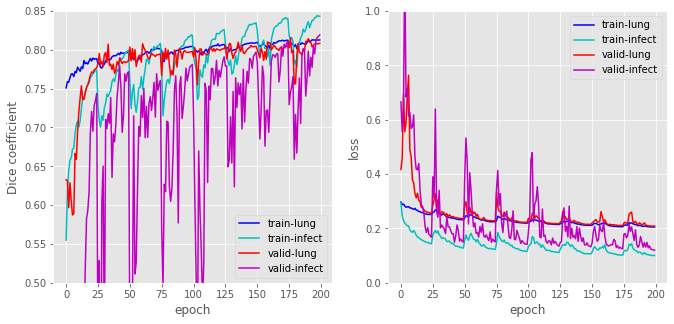

In [54]:
plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(11,5))

axes[0].plot(ctsRes.history['lung_output_dice_coeff'], color='b', label='train-lung')
axes[0].plot(ctsRes.history['infect_output_dice_coeff'], color='c', label='train-infect')
axes[0].plot(ctsRes.history['val_lung_output_dice_coeff'], color='r', label='valid-lung')
axes[0].plot(ctsRes.history['val_infect_output_dice_coeff'], color='m', label='valid-infect')
axes[0].set_ylabel('Dice coefficient')
axes[0].set_xlabel('epoch')
axes[0].legend()
axes[0].set_ylim([0.5, 0.85])

axes[1].plot(ctsRes.history['lung_output_loss'], color='b', label='train-lung')
axes[1].plot(ctsRes.history['infect_output_loss'], color='c', label='train-infect')
axes[1].plot(ctsRes.history['val_lung_output_loss'], color='r', label='valid-lung')
axes[1].plot(ctsRes.history['val_infect_output_loss'], color='m', label='valid-infect')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylim([0,1])
axes[1].legend();

In [56]:
test_result = ctsModel.evaluate(x=X_test, 
                                y={'lung_output': yl_test, 'infect_output': yi_test},
                                batch_size=batch_size)

print('Test data:\n\t Lung: %.4f loss, %.4f dice coeff\n\t Infection: %.4f loss, %.4f dice coeff' 
      %(test_result[1], test_result[3], test_result[2], test_result[4]))

3/3 [==============================] - 5s 2s/step - loss: 0.3391 - lung_output_loss: 0.2073 - infect_output_loss: 0.1318 - lung_output_dice_coeff: 0.8096 - infect_output_dice_coeff: 0.7914
Test data:
	 Lung: 0.2073 loss, 0.8096 dice coeff
	 Infection: 0.1318 loss, 0.7914 dice coeff


In [57]:
 gc.collect()

27971

### Run this if you want to train the network more

In [61]:
checkpoint_fpath = "ctsmodel-lungs-infect-seg-2.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_infect_output_dice_coeff', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)


ctsModel = cts_model(cts.shape[1:])

optim = optimizers.Adam(lr=5e-4, beta_1=0.9, beta_2=0.99)

ctsModel.compile(optimizer=optim, loss=loss_dict, loss_weights=loss_weight_dict, metrics=[dice_coeff])

ctsModel.load_weights('ctsmodel-lungs-infect-seg.hdf5')

ctsRes = ctsModel.fit(x=X_train, 
                      y={'lung_output': yl_train, 'infect_output': yi_train},
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(X_valid, 
                                       {'lung_output': yl_valid, 
                                        'infect_output': yi_valid}),
                      callbacks = [cts_checkpoint_cb])

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.3088 - lung_output_loss: 0.2053 - infect_output_loss: 0.1035 - lung_output_dice_coeff: 0.8132 - infect_output_dice_coeff: 0.8395 
Epoch 00001: val_infect_output_dice_coeff improved from -inf to 0.81115, saving model to ctsmodel-lungs-infect-seg-2.hdf5
20/20 [==============================] - 349s 17s/step - loss: 0.3088 - lung_output_loss: 0.2053 - infect_output_loss: 0.1035 - lung_output_dice_coeff: 0.8132 - infect_output_dice_coeff: 0.8395 - val_loss: 0.3347 - val_lung_output_loss: 0.2105 - val_infect_output_loss: 0.1241 - val_lung_output_dice_coeff: 0.8018 - val_infect_output_dice_coeff: 0.8112
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.3075 - lung_output_loss: 0.2054 - infect_output_loss: 0.1021 - lung_output_dice_coeff: 0.8131 - infect_output_dice_coeff: 0.8400 
Epoch 00002: val_infect_output_dice_coeff did not improve from 0.81115
20/20 [==============================] - 362s 18s/st

Epoch 14/200
20/20 [==============================] - ETA: 0s - loss: 0.2979 - lung_output_loss: 0.2018 - infect_output_loss: 0.0961 - lung_output_dice_coeff: 0.8146 - infect_output_dice_coeff: 0.8507 
Epoch 00014: val_infect_output_dice_coeff improved from 0.82113 to 0.82375, saving model to ctsmodel-lungs-infect-seg-2.hdf5
20/20 [==============================] - 364s 18s/step - loss: 0.2979 - lung_output_loss: 0.2018 - infect_output_loss: 0.0961 - lung_output_dice_coeff: 0.8146 - infect_output_dice_coeff: 0.8507 - val_loss: 0.3239 - val_lung_output_loss: 0.2057 - val_infect_output_loss: 0.1182 - val_lung_output_dice_coeff: 0.8118 - val_infect_output_dice_coeff: 0.8238
Epoch 15/200
20/20 [==============================] - ETA: 0s - loss: 0.2958 - lung_output_loss: 0.2007 - infect_output_loss: 0.0951 - lung_output_dice_coeff: 0.8154 - infect_output_dice_coeff: 0.8521 
Epoch 00015: val_infect_output_dice_coeff did not improve from 0.82375
20/20 [==============================] - 364s 1

20/20 [==============================] - ETA: 0s - loss: 0.2939 - lung_output_loss: 0.1995 - infect_output_loss: 0.0944 - lung_output_dice_coeff: 0.8158 - infect_output_dice_coeff: 0.8530 
Epoch 00027: val_infect_output_dice_coeff did not improve from 0.82375
20/20 [==============================] - 364s 18s/step - loss: 0.2939 - lung_output_loss: 0.1995 - infect_output_loss: 0.0944 - lung_output_dice_coeff: 0.8158 - infect_output_dice_coeff: 0.8530 - val_loss: 0.3347 - val_lung_output_loss: 0.2078 - val_infect_output_loss: 0.1269 - val_lung_output_dice_coeff: 0.8141 - val_infect_output_dice_coeff: 0.8126
Epoch 28/200
20/20 [==============================] - ETA: 0s - loss: 0.2934 - lung_output_loss: 0.1996 - infect_output_loss: 0.0938 - lung_output_dice_coeff: 0.8172 - infect_output_dice_coeff: 0.8538 
Epoch 00028: val_infect_output_dice_coeff did not improve from 0.82375
20/20 [==============================] - 364s 18s/step - loss: 0.2934 - lung_output_loss: 0.1996 - infect_output_l

Epoch 53/200
20/20 [==============================] - ETA: 0s - loss: 0.2863 - lung_output_loss: 0.1959 - infect_output_loss: 0.0904 - lung_output_dice_coeff: 0.8172 - infect_output_dice_coeff: 0.8591 
Epoch 00053: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 363s 18s/step - loss: 0.2863 - lung_output_loss: 0.1959 - infect_output_loss: 0.0904 - lung_output_dice_coeff: 0.8172 - infect_output_dice_coeff: 0.8591 - val_loss: 0.3321 - val_lung_output_loss: 0.2049 - val_infect_output_loss: 0.1271 - val_lung_output_dice_coeff: 0.8130 - val_infect_output_dice_coeff: 0.8064
Epoch 54/200
20/20 [==============================] - ETA: 0s - loss: 0.2873 - lung_output_loss: 0.1963 - infect_output_loss: 0.0911 - lung_output_dice_coeff: 0.8180 - infect_output_dice_coeff: 0.8590 
Epoch 00054: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 363s 18s/step - loss: 0.2873 - lung_output_loss: 0.1963 - in

20/20 [==============================] - ETA: 0s - loss: 0.2766 - lung_output_loss: 0.1926 - infect_output_loss: 0.0840 - lung_output_dice_coeff: 0.8205 - infect_output_dice_coeff: 0.8696 
Epoch 00079: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 363s 18s/step - loss: 0.2766 - lung_output_loss: 0.1926 - infect_output_loss: 0.0840 - lung_output_dice_coeff: 0.8205 - infect_output_dice_coeff: 0.8696 - val_loss: 0.3214 - val_lung_output_loss: 0.2027 - val_infect_output_loss: 0.1187 - val_lung_output_dice_coeff: 0.8167 - val_infect_output_dice_coeff: 0.8242
Epoch 80/200
20/20 [==============================] - ETA: 0s - loss: 0.2772 - lung_output_loss: 0.1924 - infect_output_loss: 0.0847 - lung_output_dice_coeff: 0.8201 - infect_output_dice_coeff: 0.8688 
Epoch 00080: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 363s 18s/step - loss: 0.2772 - lung_output_loss: 0.1924 - infect_output_l

20/20 [==============================] - ETA: 0s - loss: 0.2734 - lung_output_loss: 0.1909 - infect_output_loss: 0.0824 - lung_output_dice_coeff: 0.8209 - infect_output_dice_coeff: 0.8721 
Epoch 00105: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 363s 18s/step - loss: 0.2734 - lung_output_loss: 0.1909 - infect_output_loss: 0.0824 - lung_output_dice_coeff: 0.8209 - infect_output_dice_coeff: 0.8721 - val_loss: 0.3315 - val_lung_output_loss: 0.2014 - val_infect_output_loss: 0.1301 - val_lung_output_dice_coeff: 0.8128 - val_infect_output_dice_coeff: 0.8060
Epoch 106/200
20/20 [==============================] - ETA: 0s - loss: 0.2729 - lung_output_loss: 0.1910 - infect_output_loss: 0.0819 - lung_output_dice_coeff: 0.8207 - infect_output_dice_coeff: 0.8726 
Epoch 00106: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 363s 18s/step - loss: 0.2729 - lung_output_loss: 0.1910 - infect_output_

20/20 [==============================] - ETA: 0s - loss: 0.2693 - lung_output_loss: 0.1890 - infect_output_loss: 0.0803 - lung_output_dice_coeff: 0.8218 - infect_output_dice_coeff: 0.8753 
Epoch 00131: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 362s 18s/step - loss: 0.2693 - lung_output_loss: 0.1890 - infect_output_loss: 0.0803 - lung_output_dice_coeff: 0.8218 - infect_output_dice_coeff: 0.8753 - val_loss: 0.3240 - val_lung_output_loss: 0.2027 - val_infect_output_loss: 0.1212 - val_lung_output_dice_coeff: 0.8169 - val_infect_output_dice_coeff: 0.8169
Epoch 132/200
20/20 [==============================] - ETA: 0s - loss: 0.2708 - lung_output_loss: 0.1895 - infect_output_loss: 0.0813 - lung_output_dice_coeff: 0.8219 - infect_output_dice_coeff: 0.8739 
Epoch 00132: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 363s 18s/step - loss: 0.2708 - lung_output_loss: 0.1895 - infect_output_

20/20 [==============================] - ETA: 0s - loss: 0.2640 - lung_output_loss: 0.1883 - infect_output_loss: 0.0757 - lung_output_dice_coeff: 0.8228 - infect_output_dice_coeff: 0.8822 
Epoch 00157: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 363s 18s/step - loss: 0.2640 - lung_output_loss: 0.1883 - infect_output_loss: 0.0757 - lung_output_dice_coeff: 0.8228 - infect_output_dice_coeff: 0.8822 - val_loss: 0.3185 - val_lung_output_loss: 0.2004 - val_infect_output_loss: 0.1182 - val_lung_output_dice_coeff: 0.8168 - val_infect_output_dice_coeff: 0.8228
Epoch 158/200
20/20 [==============================] - ETA: 0s - loss: 0.2659 - lung_output_loss: 0.1878 - infect_output_loss: 0.0780 - lung_output_dice_coeff: 0.8230 - infect_output_dice_coeff: 0.8787 
Epoch 00158: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 363s 18s/step - loss: 0.2659 - lung_output_loss: 0.1878 - infect_output_

20/20 [==============================] - ETA: 0s - loss: 0.2626 - lung_output_loss: 0.1876 - infect_output_loss: 0.0751 - lung_output_dice_coeff: 0.8231 - infect_output_dice_coeff: 0.8836 
Epoch 00183: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 365s 18s/step - loss: 0.2626 - lung_output_loss: 0.1876 - infect_output_loss: 0.0751 - lung_output_dice_coeff: 0.8231 - infect_output_dice_coeff: 0.8836 - val_loss: 0.3275 - val_lung_output_loss: 0.1996 - val_infect_output_loss: 0.1279 - val_lung_output_dice_coeff: 0.8139 - val_infect_output_dice_coeff: 0.8124
Epoch 184/200
20/20 [==============================] - ETA: 0s - loss: 0.2629 - lung_output_loss: 0.1874 - infect_output_loss: 0.0754 - lung_output_dice_coeff: 0.8228 - infect_output_dice_coeff: 0.8826 
Epoch 00184: val_infect_output_dice_coeff did not improve from 0.83244
20/20 [==============================] - 365s 18s/step - loss: 0.2629 - lung_output_loss: 0.1874 - infect_output_

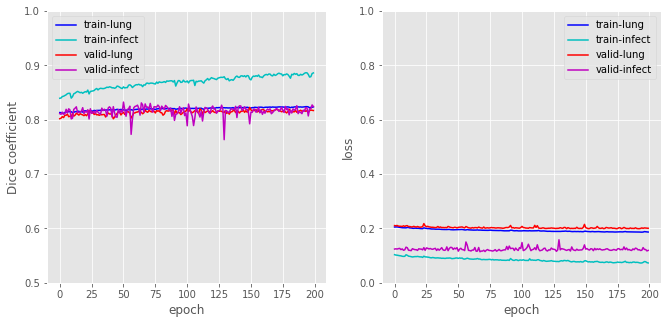

In [63]:
plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(11,5))

axes[0].plot(ctsRes.history['lung_output_dice_coeff'], color='b', label='train-lung')
axes[0].plot(ctsRes.history['infect_output_dice_coeff'], color='c', label='train-infect')
axes[0].plot(ctsRes.history['val_lung_output_dice_coeff'], color='r', label='valid-lung')
axes[0].plot(ctsRes.history['val_infect_output_dice_coeff'], color='m', label='valid-infect')
axes[0].set_ylabel('Dice coefficient')
axes[0].set_xlabel('epoch')
axes[0].legend()
axes[0].set_ylim([0.5, 1])

axes[1].plot(ctsRes.history['lung_output_loss'], color='b', label='train-lung')
axes[1].plot(ctsRes.history['infect_output_loss'], color='c', label='train-infect')
axes[1].plot(ctsRes.history['val_lung_output_loss'], color='r', label='valid-lung')
axes[1].plot(ctsRes.history['val_infect_output_loss'], color='m', label='valid-infect')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylim([0,1])
axes[1].legend();

In [67]:
test_result = ctsModel.evaluate(x=X_test, 
                                y={'lung_output': yl_test, 'infect_output': yi_test},
                                batch_size=batch_size)

print('Test data:\n\t Lung: %.4f loss, %.4f dice coeff\n\t Infection: %.4f loss, %.4f dice coeff' 
      %(test_result[1], test_result[3], test_result[2], test_result[4]))

3/3 [==============================] - 5s 2s/step - loss: 0.3225 - lung_output_loss: 0.1951 - infect_output_loss: 0.1274 - lung_output_dice_coeff: 0.8175 - infect_output_dice_coeff: 0.7987
Test data:
	 Lung: 0.1951 loss, 0.8175 dice coeff
	 Infection: 0.1274 loss, 0.7987 dice coeff


In [ ]:
# model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[sm.metrics.IOUScore(threshold=0.55)])

In [80]:
yl_pred, yi_pred = ctsModel.predict(X_test)
print(yl_pred.shape, yi_pred.shape)

(317, 100, 100, 1) (317, 100, 100, 1)


## Evaluate network performance

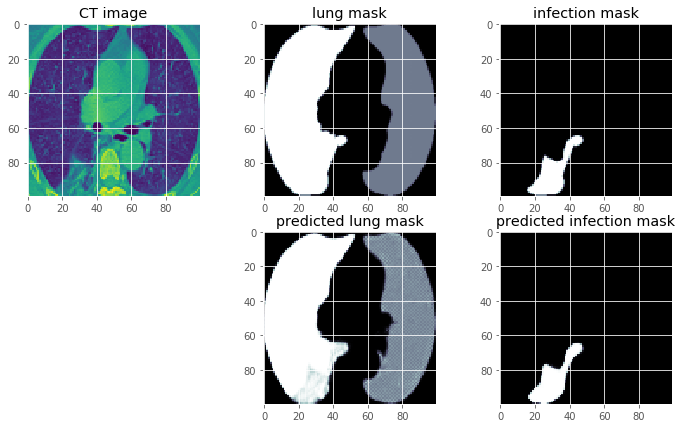

In [89]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,7))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
    plt.title('CT image')

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(yl_test[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('lung mask')

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('infection mask')

    plt.subplot(2,3,5)
    plt.imshow(tf.reshape(yl_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('predicted lung mask')

    plt.subplot(2,3,6)
    plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('predicted infection mask')
    

compare_actual_and_predicted(43)